In [1]:
import os
import sys
import smbus

from time import sleep
from datetime import datetime

In [2]:
from meerkat import ads

### Setup ADS1115

In [3]:
i2c = smbus.SMBus(1)
dev = ads.ADS1115(bus=i2c)
dev.get_config()
dev.pga('6.144')  # Other options: '6.144', '4.096'
dev.mux('1G')     # pin 1 relative to ground
dev.get_config()  # refresh for measurements

### Print Status

In [4]:
dev.print_attributes()

ADS11x5 Configuration Attributes
--------------------------------
Config Register: 20736 0x5100 0b101000100000000
PGA Range: +/- 6.144 Volts
Mode: single
Data Rate: 8 SPS
Input Multiplexer: 1G
Comparator:
 Queue: 1
 Latching: off
 Polarity: Active 1
 Mode: trad


In [5]:
def get_time():
    return datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')

### Single Tests

In [6]:
print('Measured voltage: {}'.format(dev.voltage()))

Measured voltage: 0.96225


In [7]:
print(dev.writer.create_metadata())

#!{"accuracy": null, "bytes": null, "case_sensitive_header": false, "comment": "#", "delimiter": ",", "description": null, "device": {"accuracy": null, "active": null, "bus": "<SMBus object at 0x7424aef0>", "calibration_date": null, "description": "Texas Instruments 16-bit 860SPS 4-Ch Delta-Sigma ADC with PGA", "dtype": null, "error": null, "manufacturer": "Texas Instruments", "name": "ADS1115", "pga_gain": -999, "precision": "16bit", "state": null, "urls": "www.ti.com/product/ADS1115", "version_hw": "1.0", "version_sw": "1.0"}, "double_quote": true, "dtypes": null, "encoding": "utf-8", "escape_char": "\\", "format": null, "hash": null, "header": ["sample_id", "voltage"], "licenses": null, "line_terminator": "\n", "media_type": "text/csv", "name": "ADS1115", "null_sequence": "NA", "path": null, "precision": null, "quote_char": "\"", "schema": null, "shebang": true, "skip_initial_space": true, "skip_lines": 1, "sources": null, "standard": "Follow RFC 4180", "time_format": "std_time_ms",

In [8]:
print(dev.writer.header)

['sample_id', 'voltage']


In [9]:
print(dev.get(sid='test'))

['test', 2.04825]


### File Save Test
LM4040 2.048 V reference source connected to A0

In [10]:
samples = 20

In [11]:
for _ in range(samples):
    dev.write(sid='sample_' + str(_))

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

from meerkat import parser

In [13]:
dev.writer.path

'2018_12_27_18_21_06_data.csv'

In [14]:
m, df = parser.csv_resource(dev.writer.path)

### Verify Timestamp Format

In [15]:
dev.writer._timepiece.format_used

'std_time_ms'

In [16]:
m['time_format'] == dev.writer._timepiece.format_used

True

### Plot Data

In [17]:
df['datetime64_ns'] = pd.to_datetime(df[m['time_format']])

In [18]:
df.index = df.datetime64_ns

In [19]:
df['rolling_mean'] = df.voltage.rolling(4, win_type='triang').mean()

In [20]:
df_mean = df.voltage.mean()
df['mean'] = df_mean

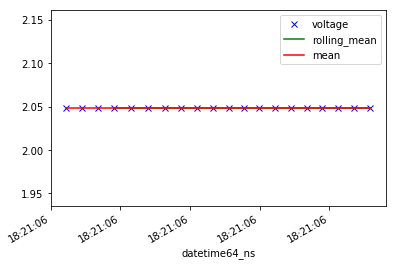

In [21]:
df[['voltage', 'rolling_mean', 'mean']].plot(style=[' xb', '-g', '-r']);

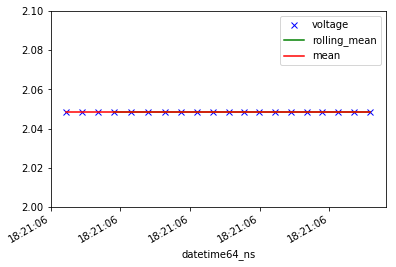

In [22]:
df[['voltage', 'rolling_mean', 'mean']].plot(style=[' xb', '-g', '-r'],
                                             ylim=(2.0, 2.1));

In [23]:
print('Mean:', df_mean, 'Volts DC')
print('Standard Deviation:', df.voltage.std())

Mean: 2.0482500000000003 Volts DC
Standard Deviation: 4.556259157007654e-16


In [24]:
dt = df.index[-1]-df.index[0]
dtt = dt.seconds + dt.microseconds / 10**6
print('Sample Rate: {:.4f} Hz'.format(len(df)/dtt))

Sample Rate: 91.5474 Hz


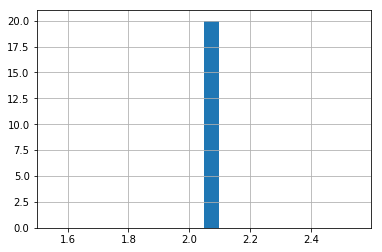

In [25]:
df.voltage.hist(bins=20);

In [26]:
dev.mode('continuous')
dev.get_config()
print('{:b}'.format(dev.config_value))
print(dev.mode_value)

1000000100000000
1


In [27]:
dev.mode('single')
dev.get_config()
print('{:b}'.format(dev.config_value))
print(dev.mode_value)

1000000100000000
1


In [28]:
bin(dev.config_value)

'0b1000000100000000'